In [2]:
#Installing packages and loading them into the enviroment
install.packages("caret")
library("caret")
install.packages("mice")
library("mice")
install.packages("MASS")
library("MASS")
install.packages("missMDA")
library("missMDA")
install.packages("tidyverse")
library("tidyverse")

Installing package into 'C:/Users/2198K/Documents/R/win-library/3.6'
(as 'lib' is unspecified)

Warning message:
"package 'caret' is in use and will not be installed"
Installing package into 'C:/Users/2198K/Documents/R/win-library/3.6'
(as 'lib' is unspecified)




  There is a binary version available but the source version is later:
     binary source needs_compilation
mice  3.9.0 3.10.0              TRUE

  Binaries will be installed


Warning message:
"package 'mice' is in use and will not be installed"
Installing package into 'C:/Users/2198K/Documents/R/win-library/3.6'
(as 'lib' is unspecified)

Warning message:
"package 'MASS' is in use and will not be installed"
Installing package into 'C:/Users/2198K/Documents/R/win-library/3.6'
(as 'lib' is unspecified)

Warning message:
"package 'missMDA' is in use and will not be installed"
Installing package into 'C:/Users/2198K/Documents/R/win-library/3.6'
(as 'lib' is unspecified)

Warning message:
"package 'tidyverse' is in use and will not be installed"


In [3]:
#Loading all needed files,dropping first two coloumns, which are not needed for analysis (ID, species)
ionomics <- read.csv('allspec_shoot_xyz_concat.csv', colClasses =c("NULL","NULL",NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,
                                                                    NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,
                                                                    NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,
                                                                    NA,NA,NA,NA,NA,NA,NA))
hybrids <- read.csv('spec_shoot_xyz_concat_unk_only.csv', colClasses = c("NULL","NULL",NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,
                                                                    NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,
                                                                    NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,
                                                                    NA,NA,NA,NA,NA,NA,NA))

#Imputation via missMDA
imputeIonomics <- imputePCA(ionomics, method = "Regularized")

In [4]:
#Imputation via Mice
# TODO add in fit graphics and missing data quantification
temp <- mice(ionomics, m = 1, maxit = 5, method = "norm.boot", seed = 123)
ionomicsComplete <- complete(temp,1)


 iter imp variable
  1   1  S34_X  As75_X
  2   1  S34_X  As75_X
  3   1  S34_X  As75_X
  4   1  S34_X  As75_X
  5   1  S34_X  As75_X


In [5]:
#data imputed with missMDA regularized method
mean.impute <- 0 #Start our average with 0
for (x in 1:10000){ # run 10000 permutations
    set.seed(x) #cycle through many random generator seeds
    training.samples.impute <- imputeIonomics$completeObs[,2] %>%
        createDataPartition(p = 0.8, list = FALSE) #split the data into training (80%) and testing (20%)
    train.data.impute <- imputeIonomics$completeObs[training.samples.impute, ] #generate training set
    test.data.impute <- imputeIonomics$completeObs[-training.samples.impute, ] #generate test set
    train.data.impute <- unlist(train.data.impute) #typecast from matrix into dataframe
    test.data.impute <- unlist(test.data.impute)
    train.data.impute <- as.data.frame(train.data.impute)
    test.data.impute <- as.data.frame(test.data.impute)
    model.impute <- lda(spec_as_int~., data = train.data.impute) #generate the LDA model
    predictions.impute <- model.impute %>% predict(test.data.impute) #predict the species of individuals in our test set based off of this model
    mean.impute = mean.impute + mean(predictions.impute$class==test.data.impute$spec_as_int) #measure how often this prediction is correct, then add it to a running total
}
mean.impute = mean.impute/9999 #divide running total by number of runs to find our average
mean.impute #print this average to the screen

#data imputed with mice, norm.boot method
mean.mice = 0 #Start our average with 0
for (x in 1:10000){ #run 10000 permutations
    set.seed(x)  #cycle through many random generator seeds
    training.samples.mice <- ionomicsComplete[,2] %>%
        createDataPartition(p = 0.8, list = FALSE) #split the data into training (80%) and testing (20%)
    train.data.mice <- ionomicsComplete[training.samples.mice, ] #generate training set
    test.data.mice <- ionomicsComplete[-training.samples.mice, ] #generate test set
    model.mice <- lda(spec_as_int~., data = train.data.mice) #generate the LDA model
    predictions.mice <- model.mice %>% predict(test.data.mice) #predict the species of individuals in our test set based off of this model
    mean.mice = mean.mice + mean(predictions.mice$class==test.data.mice$spec_as_int) #measure how often this prediction is correct, then add it to a running total
}
mean.mice = mean.mice/9999 #divide running total by number of runs to find our average
mean.mice #print this average to the screen

[1] 0.7391318

[1] 0.7390292

|species|spec_as_int|
|---|---|
|acerifolia_x|1|
|cinerea_x|3|
|labrusca_x|4|
|riparia_x|6|
|rupestris_x|7|
|vulpina_x|8|

In [6]:
df.impute <- as.data.frame(unlist(imputeIonomics$completeObs))
lda.impute <- lda(spec_as_int~., data = df.impute)
pred.impute <- predict(lda.impute)
pred.hybrids <- lda.impute %>% predict(hybrids)

In [7]:
viz.impute <- data.frame(spec = df.impute[1], lda = pred.impute$x)
viz.hybrids <- data.frame(spec = hybrids[1], lda = pred.hybrids$x)
#viz.impute$spec = as.factor(viz.impute$spec)
#viz.hybrids$spec = as.factor(viz.hybrids$spec)

In [8]:
p <- ggplot(data = NULL) 
p + geom_point(data = viz.impute + aes(x = lda.LD1, y = lda.LD2, color = spec)) 
p + geom_step(data = viz.hybrids + aes(x = lda.LD1, y = lda.LD2, color = spec.))

ERROR: Error in Ops.data.frame(viz.impute, aes(x = lda.LD1, y = lda.LD2, color = spec)): list of length 3 not meaningful


In [9]:
# Split the data into training (80%) and test set (20%)
#data set imputed via mice
set.seed(321)
training.samples <- ionomicsComplete[,2] %>%
  createDataPartition(p = 0.8, list = FALSE)
train.data <- ionomicsComplete[training.samples, ]
test.data <- ionomicsComplete[-training.samples, ]

In [10]:
#unimputed
training.samples.raw <- ionomics[,2] %>%
  createDataPartition(p = 0.8, list = FALSE)
train.data.raw <- ionomics[training.samples.raw, ]
test.data.raw <- ionomics[-training.samples.raw, ]

In [11]:
#data set imputed via missMDA
training.samples.impute <- imputeIonomics$completeObs[,2] %>%
  createDataPartition(p = 0.8, list = FALSE)
train.data.impute <- imputeIonomics$completeObs[training.samples.impute, ]
test.data.impute <- imputeIonomics$completeObs[-training.samples.impute, ]
#typecasting from matrix to dataframe
train.data.impute <- unlist(train.data.impute)
test.data.impute <- unlist(test.data.impute)
train.data.impute <- as.data.frame(train.data.impute)
test.data.impute <- as.data.frame(test.data.impute)

In [12]:
# Fit the model
#data set imputed with mice
model <- lda(spec_as_int~., data = train.data)
# Make predictions
predictions <- model %>% predict(test.data)
# Model accuracy
mean(predictions$class==test.data$spec_as_int)
model

[1] 0.5526316

Call:
lda(spec_as_int ~ ., data = train.data)

Prior probabilities of groups:
      1       2       3       4       5       6       7       8 
0.06875 0.03125 0.13125 0.18750 0.03125 0.36250 0.13125 0.05625 

Group means:
        B11_X      B11_Y       B11_Z      Na23_X     Na23_Y      Na23_Z
1 -0.12871166 -0.3767546 -0.09975718 0.004857441 -0.5435771  0.37442837
2 -0.20849109 -0.4496876 -0.23917759 0.858489923 -0.5250118 -0.63640511
3 -0.09940241 -0.1900409 -0.54334278 1.686510739 -0.1458339 -0.43399837
4  0.34162432 -0.3344615 -0.37798398 1.043500340 -0.4853948 -0.29150611
5  2.17579639 -0.7712414 -0.94398132 2.196069320 -0.4609158 -0.04792838
6  0.69329702 -0.1880709  0.20689993 0.663556787 -0.6733342 -0.18518178
7  0.69578683 -0.1481565  0.16977511 0.403643945 -0.7405632 -0.44262304
8 -0.64262001 -0.1446168 -0.30576116 0.053552924 -0.7043877 -0.63754494
      Mg26_X      Mg26_Y    Mg26_Z       Al27_X     Al27_Y     Al27_Z
1 -0.8172900 -0.72078168 1.1603830  0.208267219 -0.8717691  

In [13]:
#unimputed
model.raw <- lda(spec_as_int~., data = train.data.raw)
# Make predictions
predictions.raw <- model.raw %>% predict(test.data.raw)
# Model accuracy
mean(predictions.raw$class==test.data.raw$spec_as_int)
model.raw

Warning message in FUN(newX[, i], ...):
"no non-missing arguments to min; returning Inf"


[1] NA

Call:
lda(spec_as_int ~ ., data = train.data.raw)

Prior probabilities of groups:
         1          2          3          4          5          6          7 
0.05769231 0.02564103 0.13461538 0.23717949 0.02564103 0.33333333 0.12820513 
         8 
0.05769231 

Group means:
       B11_X       B11_Y      B11_Z      Na23_X     Na23_Y       Na23_Z
1 -0.3453912 -0.44857387 -0.1137907 -0.08813508 -0.6369059  0.175079422
2 -0.7998088 -0.43199088 -0.5078684  0.37677869 -0.5465314 -0.744310945
3  0.1186949 -0.08377124 -0.4562354  1.84166205 -0.1004425 -0.421853350
4  0.3373450 -0.35152964 -0.3731695  1.18079097 -0.4170612 -0.289501610
5  2.6007978 -0.75038790 -0.8681802  2.07757345 -0.4957578 -0.005149697
6  0.6926944 -0.20454752  0.2101521  0.65272219 -0.6497065 -0.116083888
7  0.3979657 -0.20178773  0.1361210  0.31928280 -0.7581330 -0.412382454
8 -0.3410252 -0.01403139 -0.1124122  0.29376824 -0.6439650 -0.546205317
      Mg26_X      Mg26_Y    Mg26_Z      Al27_X     Al27_Y      Al27_Z
1 -0.7

In [14]:
#data set imputed with missMDA
model.impute <- lda(spec_as_int~., data = train.data.impute)
# Make predictions
predictions.impute <- model.impute %>% predict(test.data.impute)
# Model accuracy
mean(predictions.impute$class == test.data.impute$spec_as_int)
model.impute
#TODO format data generated by model

[1] 0.6842105

Call:
lda(spec_as_int ~ ., data = train.data.impute)

Prior probabilities of groups:
      1       2       3       4       5       6       7       8 
0.06875 0.03125 0.12500 0.21875 0.03125 0.35000 0.12500 0.05000 

Group means:
        B11_X       B11_Y       B11_Z      Na23_X     Na23_Y      Na23_Z
1 -0.20641666 -0.40313713 -0.20574912 -0.04371864 -0.5430634  0.43307153
2 -0.22676827 -0.45076773 -0.15087665  0.79274082 -0.5128003 -0.64255067
3 -0.09870739 -0.01014486 -0.47868445  1.82358407 -0.0248748 -0.38419114
4  0.48856157 -0.34199747 -0.40041003  1.24999447 -0.4257597 -0.26961156
5  2.17579639 -0.77124136 -0.94398132  2.19606932 -0.4609158 -0.04792838
6  0.35402031 -0.19484202  0.20970578  0.50130214 -0.6802134 -0.16840350
7  0.51738131 -0.14010642  0.09345827  0.24131501 -0.7400383 -0.53828971
8  0.21607021 -0.10094330 -0.19812868  0.17412844 -0.5979598 -0.62230397
      Mg26_X      Mg26_Y    Mg26_Z      Al27_X     Al27_Y      Al27_Z
1 -0.8079438 -0.77888367 0.9449621 -0.065261

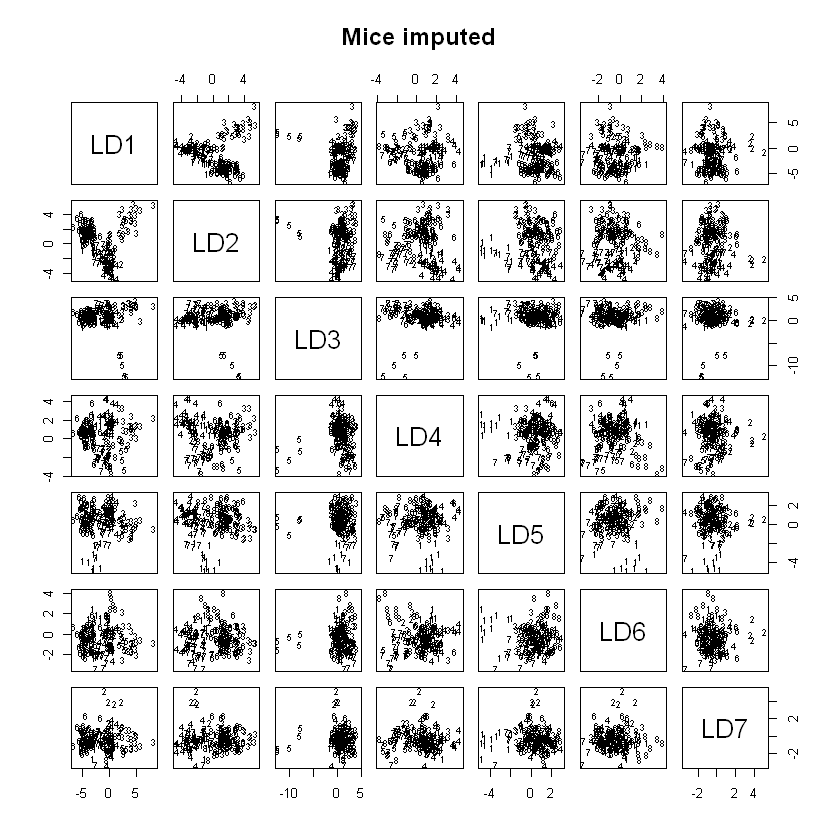

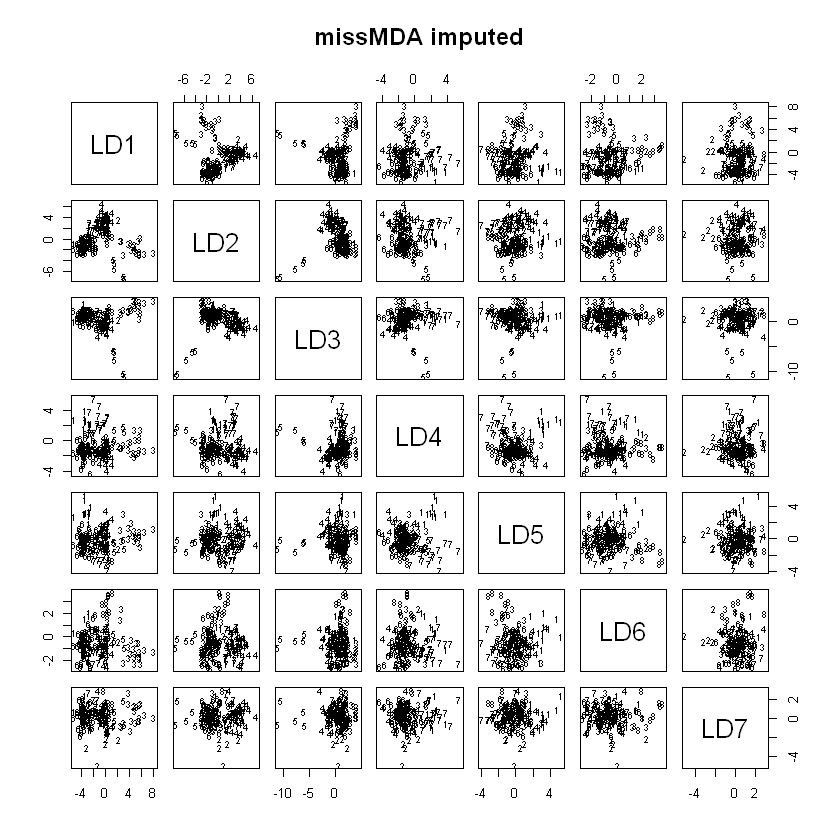

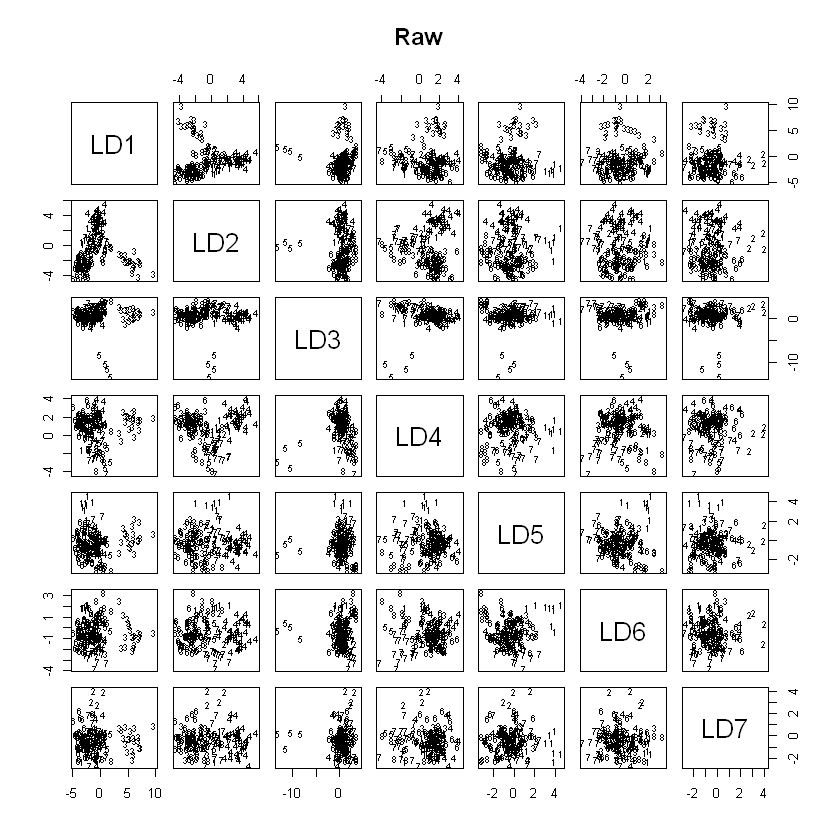

In [15]:
plot(model,main = "Mice imputed")
plot(model.impute, main = "missMDA imputed")
plot(model.raw, main = "Raw")
#TODO a better way to do this 

In [16]:
#mice imputed data
# Predicted classes
head(predictions$class, 6)
# Predicted probabilities of class memebership.
head(predictions$posterior, 6) 
# Linear discriminants
head(predictions$x, 3)

[1] 1 6 3 5 6 2
Levels: 1 2 3 4 5 6 7 8

,1,2,3,4,5,6,7,8
10,9.917190e-01,1.897394e-07,2.380119e-18,1.808013e-07,1.824202e-36,8.276129e-03,4.511979e-06,1.858229e-11
13,7.252321e-07,7.122769e-10,2.055153e-14,4.845375e-08,4.778603e-42,9.999661e-01,3.315707e-05,9.330650e-10
24,5.110266e-15,3.615453e-21,9.999998e-01,1.091527e-19,1.868553e-33,1.655221e-07,2.674688e-12,2.533704e-15
26,4.042823e-27,7.323031e-10,2.052054e-19,5.934607e-15,1.000000e+00,6.803727e-25,1.553909e-25,3.901671e-15
30,2.647510e-07,2.019340e-15,9.578423e-10,3.449100e-05,2.743198e-49,5.125986e-01,4.873667e-01,1.305848e-08
38,1.045590e-19,9.975566e-01,3.261481e-05,2.993397e-04,5.632706e-28,7.677723e-15,2.527286e-09,2.111453e-03


,LD1,LD2,LD3,LD4,LD5,LD6,LD7
10,-2.553763,-0.6843277,-0.6985519,0.4711280,-2.67232479,1.0530224,1.413550
13,-2.417924,0.7141517,1.0370735,0.2865061,0.05918994,-0.5832576,0.769432
24,2.081650,6.6240014,1.2255211,-0.3252432,-1.90506192,-2.4901877,-1.512422


In [17]:
#missMDA imputed data
# Predicted classes
head(predictions.impute$class, 6)
# Predicted probabilities of class memebership.
head(predictions.impute$posterior, 6) 
# Linear discriminants
head(predictions.impute$x, 3)

[1] 4 8 3 3 5 7
Levels: 1 2 3 4 5 6 7 8

,1,2,3,4,5,6,7,8
1,2.695880e-11,2.899408e-04,8.457480e-16,9.996810e-01,4.373940e-39,1.481594e-06,1.912783e-05,8.413157e-06
2,2.967461e-07,1.705622e-01,4.721771e-11,5.796830e-02,4.411127e-34,1.033322e-03,1.883458e-03,7.685524e-01
3,2.248527e-22,1.098198e-04,9.998056e-01,2.754242e-06,1.664808e-41,4.937772e-12,1.755703e-11,8.183177e-05
4,7.694618e-20,8.543553e-17,1.000000e+00,1.130973e-22,7.111839e-24,2.876647e-13,2.282301e-18,2.088884e-17
5,6.620630e-22,8.933988e-13,2.111935e-03,1.654162e-14,9.978879e-01,6.426063e-12,5.387028e-18,1.339163e-07
6,2.652429e-07,2.091903e-08,2.043740e-11,1.192383e-02,1.432486e-43,7.268656e-03,9.808068e-01,4.382710e-07


,LD1,LD2,LD3,LD4,LD5,LD6,LD7
1,-0.29315321,3.388058,-0.5163662,-1.3028263,-0.02774507,0.6536196,-0.4855693
2,0.02095507,1.654665,0.3059896,-0.2767072,-0.34812268,2.5332961,-0.8633016
3,5.19994083,1.209041,2.5388844,-3.2573726,-0.86443076,0.1543515,-1.6918712


In [18]:
#raw data
# Predicted classes
head(predictions.raw$class, 6)
# Predicted probabilities of class memebership.
head(predictions.raw$posterior, 6) 
# Linear discriminants
head(predictions.raw$x, 3)

[1] 1 1 6 2 4 2
Levels: 1 2 3 4 5 6 7 8

,1,2,3,4,5,6,7,8
4,9.992438e-01,5.210992e-12,1.718927e-18,3.474849e-10,1.424805e-31,7.534273e-04,2.799522e-06,8.132638e-18
8,9.999997e-01,2.315975e-14,1.521813e-19,4.745967e-08,2.677986e-44,5.915041e-08,1.477572e-07,1.075694e-16
9,8.256710e-06,5.183777e-11,7.498756e-35,2.962939e-05,3.423419e-51,9.999443e-01,1.206192e-05,5.785269e-06
14,1.625163e-06,9.941640e-01,4.170881e-18,1.044881e-03,1.502826e-39,4.292617e-03,4.968357e-04,2.340339e-08
15,1.565422e-05,1.901989e-06,8.124073e-10,9.995168e-01,2.880694e-32,2.974721e-04,1.663965e-04,1.746082e-06
19,7.844233e-09,9.932332e-01,7.884812e-18,1.841132e-08,2.379819e-39,1.882843e-03,4.202618e-03,6.813274e-04


,LD1,LD2,LD3,LD4,LD5,LD6,LD7
4,-2.289500,-1.1127975,-1.5636087,-0.3932398,4.883612,-0.4171444,-0.7107377
8,-1.686752,0.9623113,0.5406493,0.6870731,4.932951,0.8271480,-2.6493580
9,-7.213533,1.3176153,2.0163100,-0.0621940,-3.051639,1.9034394,-2.2742059


In [19]:
#raw data
table.raw <- table(Predicted=predictions.raw$class, Species=test.data.raw$spec_as_int)
confusionMatrix(table.raw)

Confusion Matrix and Statistics

         Species
Predicted  1  2  3  4  5  6  7  8
        1  2  0  0  0  0  1  0  0
        2  0  1  2  0  0  0  0  1
        3  0  0  4  0  0  0  0  0
        4  0  1  0  3  0  0  1  1
        5  0  0  0  0  0  0  0  0
        6  1  0  0  0  1 12  0  0
        7  0  0  1  0  0  0  3  0
        8  0  0  0  0  0  2  0  0

Overall Statistics
                                          
               Accuracy : 0.6757          
                 95% CI : (0.5021, 0.8199)
    No Information Rate : 0.4054          
    P-Value [Acc > NIR] : 0.000814        
                                          
                  Kappa : 0.5874          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4 Class: 5 Class: 6
Sensitivity           0.66667  0.50000   0.5714  1.00000  0.00000   0.8000
Specificity           0.97059  0.91429   1.0000  0.91176  1.0000

In [20]:
#missMDA data
table.impute <- table(Predicted=predictions.impute$class, Species=test.data.impute$spec_as_int)
con <- confusionMatrix(table.impute)
names(con)
names(con$overall)

ERROR: Error in !all.equal(nrow(data), ncol(data)): invalid argument type


In [21]:
#mice data
table <- table(Predicted=predictions$class, Species=test.data$spec_as_int)
confusionMatrix(table)

ERROR: Error in !all.equal(nrow(data), ncol(data)): invalid argument type
